# Assignment 6 - Group Assignment 1

## A bit of info before you start.


> ***First and foremost, dont use AI to code. Use it to understand and then write code yourself. Use AI to verify if the code you wrote it correct, that will help you learn far far more.***

> ***Use cv2 functions only or atleast wherever possible.***

> **This assignment marks 1/3rd of your project. And hence, it is the first part of the final submission from your team.**







## Create a DataLoader Class

Use the pytorch docs sent on group and deepen your understanding using sample practice, or even AI.

Finally, create a dataloader for the Fruits-360 dataset ( https://www.kaggle.com/datasets/moltean/fruits ).
In <code>__getitem__</code> , include the processing to create LBP image, canny image, and find the 6 color features and 6 shape features.
Best implementation should include a proper division of tasks between the method itself and utility functions.
Also brainstorm about the data structures you use to process and pass the info. Use cv2 functions for best performance.

In [9]:
import os

# Setting credentials for download
os.environ['KAGGLE_USERNAME'] = "adityadurgapal"
os.environ['KAGGLE_KEY'] = "108068522ff5ff973c8025a6911f670a"

# Downloading the Fruits-360 dataset
if not os.path.exists('fruits.zip'):
    print("Downloading dataset... please wait.")
    !kaggle datasets download -d moltean/fruits
else:
    print("Dataset zip already exists.")

# Unzipping the dataset
if not os.path.exists('fruits-360_dataset'):
    print("Unzipping dataset...")
    !unzip -q fruits.zip -d fruits-360_dataset
    print("Unzipping complete!")
else:
    print("Dataset already unzipped.")

Dataset zip already exists.
Dataset already unzipped.


In [10]:
#Verifying the correct path with the training data
import os
training_path = 'fruits-360_dataset/fruits-360_100x100/fruits-360/Training'

if os.path.exists(training_path):
    print("Path Verified! I can see the fruit folders.")
    # Show the first 5 fruit categories found
    folders = sorted(os.listdir(training_path))
    print(f"Total fruit types found: {len(folders)}")
    print(f"Sample categories: {folders[:5]}")
else:
    print("Path not found. We need to double-check the folder names in your sidebar.")

Path Verified! I can see the fruit folders.
Total fruit types found: 237
Sample categories: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14']


In [11]:
import cv2
import numpy as np

# COLOR FEATURES (6 linear features)
def extract_color_features(img_bgr):
    # Converting to HSV to get better color info than raw RGB
    hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # Getting Mean and StdDev for H, S, and V channels
    means, stds = cv2.meanStdDev(hsv_img)

    # Flattening into a 1D array of 6 features
    return np.concatenate([means.flatten(), stds.flatten()]).astype(np.float32)

# SHAPE FEATURES (6 linear features)
def extract_shape_features(img_bgr):
    # Using a mask instead of Canny for contours
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Background is white (~255), so we threshold at 250 to isolate the fruit
    _, mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)

    # Finding contours on the clean mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros(6, dtype=np.float32)

    cnt = max(contours, key=cv2.contourArea)

    # Calculations
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    x, y, w, h = cv2.boundingRect(cnt)

    # Feature 1: Area Ratio
    area_ratio = area / (img_bgr.shape[0] * img_bgr.shape[1])

    # Feature 2: Aspect Ratio (Width/Height)
    aspect_ratio = float(w) / h if h != 0 else 0

    # Feature 3: Solidity (Contour Area / Hull Area)
    hull = cv2.convexHull(cnt)
    solidity = area / cv2.contourArea(hull) if cv2.contourArea(hull) > 0 else 0

    # Feature 4: Circularity
    circularity = (4 * np.pi * area) / (perimeter**2) if perimeter > 0 else 0

    # Features 5 & 6: Hu Moments (First two in log scale)
    moments = cv2.moments(cnt)
    hu = cv2.HuMoments(moments).flatten()
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-12)

    return np.array([area_ratio, aspect_ratio, solidity, circularity, hu_log[0], hu_log[1]], dtype=np.float32)

# PROCESSED IMAGES (The 2 Filtered Images)
def get_processed_images(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # IMAGE 1: LBP Image (Texture)
    lbp = np.zeros_like(gray, dtype=np.uint8)
    # Using the np.roll 'smart move' bit manipulation from session notes
    neighbors = [(-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1)]
    for idx, (dy, dx) in enumerate(neighbors):
        shifted = np.roll(np.roll(gray, dy, axis=0), dx, axis=1)
        lbp |= ((shifted >= gray).astype(np.uint8) << (7 - idx))

    # IMAGE 2: Canny Image (Edge skeleton)
    # We still need this image as output, even if we didn't use it for shapes
    canny = cv2.Canny(gray, 100, 200)

    return lbp, canny

In [12]:
import os
import torch
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class Fruits360Dataset(Dataset):
    def __init__(self, root_dir):
        """
        initializes the file paths and class mapping.
        """
        # Grabbing all JPG file paths from subfolders
        self.file_paths = glob(os.path.join(root_dir, '*/*.jpg'))

        # Extracting unique class names from the folder names
        # Folder structure is: .../Training/Fruit_Name/image.jpg
        categories = sorted(list(set([os.path.basename(os.path.dirname(f)) for f in self.file_paths])))

        # Mapping names to numbers (e.g., 'Apple' to 0)
        self.class_to_idx = {cls: i for i, cls in enumerate(categories)}

    def __len__(self):
        """
        Returns the total count of images in the dataset.
        """
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        loads one image and processes it into the required output
        """
        img_path = self.file_paths[idx]

        # Loading image with OpenCV
        img_bgr = cv2.imread(img_path)
        # BGR to RGB for the 'original image' output
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        # Grayscale for filter processing
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        # Getting the 12 numerical features (6 Color + 6 Shape)
        color_feats = extract_color_features(img_bgr)
        shape_feats = extract_shape_features(img_bgr)

        # Getting the 2 processed images (LBP and Canny)
        lbp_img, canny_img = get_processed_images(img_bgr)

        # Extracting the numeric label
        label_name = os.path.basename(os.path.dirname(img_path))
        label = self.class_to_idx[label_name]

        # Converting everything to PyTorch Tensors

        # Original Image: (H, W, C) to (C, H, W) and normalized to [0, 1]
        original_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0

        # Processed Images: Stack LBP and Canny as 2 channels in one tensor
        # Normalizing to [0, 1] as well
        lbp_tensor = torch.from_numpy(lbp_img).float() / 255.0
        canny_tensor = torch.from_numpy(canny_img).float() / 255.0
        processed_tensor = torch.stack([lbp_tensor, canny_tensor], dim=0)

        # Linear Features: Combining the features into a single vector of 12 numbers
        linear_feats_tensor = torch.from_numpy(np.concatenate([color_feats, shape_feats]))

        # Final Package for the DataLoader
        return {
            'original': original_tensor,
            'processed': processed_tensor,
            'features': linear_feats_tensor,
            'label': torch.tensor(label, dtype=torch.long)
        }

# INITIALIZING THE LOADER
TRAIN_PATH = 'fruits-360_dataset/fruits-360_100x100/fruits-360/Training'

# Creating the dataset instance
fruit_dataset = Fruits360Dataset(root_dir=TRAIN_PATH)

# Creating the DataLoader
# num_workers=2 allows the CPU to process images in parallel while training
fruit_loader = DataLoader(fruit_dataset, batch_size=32, shuffle=True, num_workers=2)

print(f"DataLoader initialized with {len(fruit_dataset)} images.")

DataLoader initialized with 124716 images.


The Linear Features Tensor has the following structure:

0-Mean Hue  

1-Mean Saturation

2-Mean Value,The average brightness of the fruit

3-Std Dev Hue

4-Std Dev Saturation

5-Std Dev Value

6-Area Ratio,Percentage of the 100x100 frame filled by the fruit.

7-Aspect Ratio

8-Solidity

9-Circularity

10-Hu Moment 1

11-Hu Moment 2

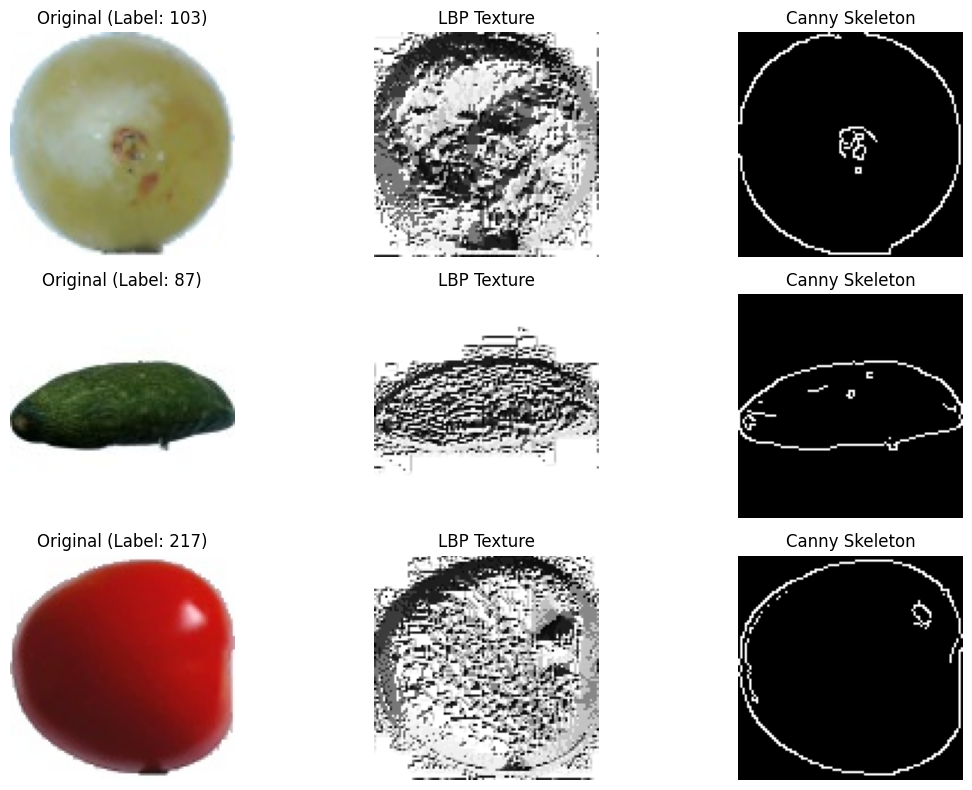


Linear Features for the first fruit:
[ 40.9169      60.9036     178.8676      30.327637    48.341236
  44.190067     0.7802       1.010101     0.98534983   0.85345423
   0.79791373   5.955666  ]


In [13]:
import matplotlib.pyplot as plt

# Grabing exactly one batch (32 images) from the loader
data_batch = next(iter(fruit_loader))

# Extracting the different parts of the package
originals = data_batch['original']   # Shape: [32, 3, 100, 100]
processed = data_batch['processed'] # Shape: [32, 2, 100, 100]
features = data_batch['features']   # Shape: [32, 12]
labels = data_batch['label']

# Plotting the first 3 fruits in the batch to verify
plt.figure(figsize=(12, 8))
for i in range(3):
    # Original RGB Image
    plt.subplot(3, 3, i*3 + 1)
    # Permute back to (H, W, C) for matplotlib
    plt.imshow(originals[i].permute(1, 2, 0))
    plt.title(f"Original (Label: {labels[i].item()})")
    plt.axis('off')

    # LBP Texture (Channel 0 of processed tensor)
    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(processed[i][0], cmap='gray')
    plt.title("LBP Texture")
    plt.axis('off')

    # Canny Edges (Channel 1 of processed tensor)
    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(processed[i][1], cmap='gray')
    plt.title("Canny Skeleton")
    plt.axis('off')

plt.tight_layout()
plt.show()

#Printing the 12 linear features for the first fruit to check the math
print(f"\nLinear Features for the first fruit:\n{features[0].numpy()}")